# Analisis del Proyecto Van Y Ven


In [1]:
# Importando modulos de análisis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") # estilo de salida de las gráficas
from datetime import datetime

In [2]:
# Leyendo los datos
viajes = pd.read_csv('./../data/2018-10.csv')
viajes.head()

,Genero_Usuario,Edad_Usuario,Autobus,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo
0,M,58,2176,299,01/10/2018,00:00:02,75,01/10/2018,00:12:02
1,F,42,9816,43,01/10/2018,00:00:23,256,01/10/2018,00:15:02
2,M,30,11219,37,01/10/2018,00:00:34,1,01/10/2018,00:09:09
3,M,26,3910,123,01/10/2018,00:01:36,182,01/10/2018,00:37:22
4,M,29,11487,41,01/10/2018,00:02:39,30,01/10/2018,00:11:29


In [3]:
# concatenar Hora_Retiro y Fecha_Retiro
viajes['fecha_hora_retiro'] = viajes.Fecha_Retiro + ' ' + viajes.Hora_Retiro

# cambiar de str a datetime
viajes['fecha_hora'] = viajes.fecha_hora_retiro \
                             .map(lambda x : datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

# reindexar el dataframe
viajes.index = viajes.fecha_hora

# limpiar valores de otros años
viajes = viajes.loc['2018-10']
viajes.head()

,Genero_Usuario,Edad_Usuario,Autobus,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,fecha_hora_retiro,fecha_hora
fecha_hora,,,,,,,,,,,
2018-10-01 00:00:02,M,58,2176,299,01/10/2018,00:00:02,75,01/10/2018,00:12:02,01/10/2018 00:00:02,2018-10-01 00:00:02
2018-10-01 00:00:23,F,42,9816,43,01/10/2018,00:00:23,256,01/10/2018,00:15:02,01/10/2018 00:00:23,2018-10-01 00:00:23
2018-10-01 00:00:34,M,30,11219,37,01/10/2018,00:00:34,1,01/10/2018,00:09:09,01/10/2018 00:00:34,2018-10-01 00:00:34
2018-10-01 00:01:36,M,26,3910,123,01/10/2018,00:01:36,182,01/10/2018,00:37:22,01/10/2018 00:01:36,2018-10-01 00:01:36
2018-10-01 00:02:39,M,29,11487,41,01/10/2018,00:02:39,30,01/10/2018,00:11:29,01/10/2018 00:02:39,2018-10-01 00:02:39


In [4]:
# resample y agregacion por dia de mes
viajes_resample_day = viajes.Autobus.resample('H').count()

# asignar día de la semana
df_resample = pd.concat([viajes_resample_day], axis=1)
df_resample['dayofweek'] = df_resample.index.dayofweek # 0 es lunes

# lunes a viernes
df_mon_to_fri = df_resample[df_resample.dayofweek.isin([0,1,2,3,4])].Autobus
df_mon_to_fri.head()

fecha_hora
2018-10-01 00:00:00    47
2018-10-01 01:00:00     0
2018-10-01 02:00:00     0
2018-10-01 03:00:00     0
2018-10-01 04:00:00     0
Name: Autobus, dtype: int64

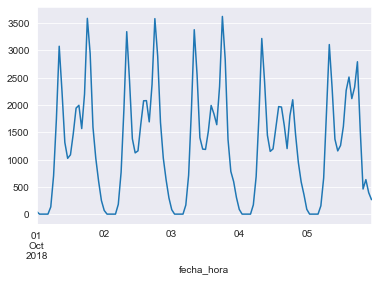

In [5]:
df_mon_to_fri[0:(24*5)].plot()
plt.show()

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# definir conjunto de datos
x = df_mon_to_fri

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 24))

# ajustar modelo
results = sarima_model.fit()

# mirar el AIC
results.aic

C:\Users\carna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\carna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


7113.315343393358

C:\Users\carna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


KeyError: 'lower Bici'

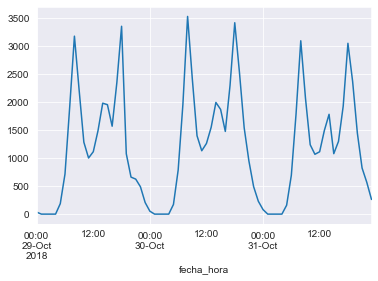

In [7]:
# tomar de datos originales dias 29-oct, 30-oct, y 31-oct
df_29_31 = df_mon_to_fri.loc['2018-10-29':'2018-10-31']
df_29_31.plot()

# agregar bandas de confianza
pred_1_2_conf = results.get_forecast(steps=24*2).conf_int()
pred_1_2_conf.index = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
x = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
y1 = pred_1_2_conf['lower Bici']
y2 = pred_1_2_conf['upper Bici']
plt.fill_between(x, y1, y2, alpha=0.6)

# predecir para 1-nov y 2-nov
pred_1_2 = results.get_forecast(steps=24*2).predicted_mean
pred_1_2.index = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
pred_1_2.plot()

# formato de la grafica final
plt.title('Pronóstico de viajes')
plt.ylabel('Cantidad de viajes')
# plt.xlabel('Semana lun-29-oct al vie-02-nov')
plt.xlabel(' ')
plt.legend(('Datos originales octubre', 'Pronóstico noviembre'),
           loc='lower left')
plt.savefig('pronostico.png', dpi=200)
plt.show()